In [1]:
# get to work without crashing all the time
# test for 1000 image and see how much the error is.
# change augmentation to make it easier and test again?
# try this later: https://mzucker.github.io/2016/10/11/unprojecting-text-with-ellipses.html

In [2]:
#!/usr/bin/python3
# https://stackoverflow.com/questions/34981144/split-text-lines-in-scanned-document
import numpy as np
import argparse
import cv2
import os

from PIL import Image
import random

from imgaug import augmenters as iaa
import imgaug as ia

%matplotlib inline
from matplotlib import pyplot as plt

## Image Augmentations
Add background

Rotate

In [3]:
max_foreground_size = 300
scaler = 2
test_folder_name = "open_cv_test"

# create test folder
try:
    os.mkdir(test_folder_name)
except FileExistsError:
    print("%s folder already created!" % test_folder_name)

In [ ]:
def add_background_and_zoom_img(foreground, background, max_foreground_size, scaler):
    """
    OLD OLD OLD
    """
    width = foreground.size[0]
    height = foreground.size[1]

    if(width > height):
        percentage = max_foreground_size/width
        max_size = int(width*scaler*percentage)
    else:
        percentage = max_foreground_size/height
        max_size = int(height*scaler*percentage)
        
#     print(width, height, percentage)

    foreground = foreground.resize((int(width*percentage), int(height*percentage)), Image.ANTIALIAS)

    background = background.resize((max_size, max_size), Image.ANTIALIAS)

    margin_w = int((background.size[0]-foreground.size[0])/2)
    margin_h = int((background.size[1]-foreground.size[1])/2)

    # foreground.show()
    background.paste(foreground, (margin_w, margin_h))
#     background.show()

    return background

In [4]:
def add_background_img(foreground, background, max_foreground_size, scaler):
    width = foreground.size[0]
    height = foreground.size[1]
#     print(width, height)

    if(width > height):
        max_size = int(width*scaler)
    else:
        max_size = int(height*scaler)
        
#     print(max_size)
        
#     print(width, height, percentage)

    foreground = foreground.resize((int(width), int(height)), Image.ANTIALIAS)
    background = background.resize((max_size, max_size), Image.ANTIALIAS)

    margin_w = int((background.size[0]-foreground.size[0])/2)
    margin_h = int((background.size[1]-foreground.size[1])/2)

    # foreground.show()
    background.paste(foreground, (margin_w, margin_h))
#     background.show()

    return background

In [5]:
def augment_image(foreground, background, max_foreground_size, scaler):
    # load image with background
    open_cv_image = np.array(add_background_img(foreground, background, max_foreground_size, scaler).convert('RGB'))

    # Convert RGB to BGR
    open_cv_image = open_cv_image[:, :, ::-1].copy() 

    # define augmentations
    rotation = random.uniform(-45,45)
    shear = 0 # random.uniform(-10,10)

    # 2. Add some more distortions
    blur_aug = ia.augmenters.blur.MotionBlur(k=(3,10), angle=(0, 360), direction=(-1.0, 1.0))
    
    # 3. Rotate and sheer image
    rotate_aug = ia.augmenters.geometric.Affine(rotate=rotation)
    shear_aug = ia.augmenters.geometric.Affine(shear=shear)
    
    # exectue augmentation
    new_img = blur_aug.augment_image(open_cv_image)
    new_img = rotate_aug.augment_image(new_img)
    new_img = shear_aug.augment_image(new_img)

    # show
    img = cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB)
    img = Image.fromarray(img)
#     img.show()

    # crop image
    rand_scaler = scaler/1.3 #*random.uniform(0.7,1.3)
#     print("rand_scaler", rand_scaler)
    crop_side_percentage = (rand_scaler-1)/(2*rand_scaler)

    area = (
        img.size[0]*crop_side_percentage, # width left
        img.size[1]*crop_side_percentage, # height top
        img.size[0]*(1-crop_side_percentage), # width right
        img.size[1]*(1-crop_side_percentage), # height bottom
    )
    cropped_img = img.crop(area)
#     cropped_img.show()
    
    return cropped_img, rotation, shear

## Crop Background

In [6]:
def get_image(background_img_names, input_img_names, max_foreground_size, scaler):
    background = Image.open(os.path.join(background_img_folder, random.choice(background_img_names)))
    foreground = Image.open(os.path.join(input_data_folder, random.choice(input_img_names)))

    return add_background_img(foreground, background, max_foreground_size, scaler)

In [7]:
def crop_background(input_img, dev=False):
    """
    Function which crops background out of image.
    Contrast has to be set to at least 240-250 to crop out gray backgrounds.
    White backgrounds are impossible to crop with this method as thresholds
    are used which don't work if the paper color is the same as the background
    """
    
    # (1) convert to CV2
    img_rgb = np.array(input_img.convert('RGB'))
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
    if(dev):
        img_show(gray, 12, True)

    # (2) gray -> black & white
    frame_threshed = cv2.inRange(gray, 250, 255)
    if(dev):
        img_show(frame_threshed, 12, True)

    # (3) get thresholds
    ret,thresh = cv2.threshold(frame_threshed,250,255,0)
    contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    # contours, hierarchy

    # (4) Find the index of the largest contour
    areas = [cv2.contourArea(c) for c in contours]
    max_index = np.argmax(areas)
    cnt=contours[max_index]

    # (5) get bounding box
    x,y,w,h = cv2.boundingRect(cnt)
    if(dev):
        print(x,y,w,h)
    bounding_box_img = cv2.rectangle(img_rgb,(x,y),(x+w,y+h),(0,255,0),2)
    if(dev):
        img_show(img_rgb, 12, True)

    # (6) crop image
    cropped_img = gray[y:y+h, x:x+w]
    if(dev):
        img_show(cropped_img, 12, True)
    
    return bounding_box_img, cropped_img

## Helper Functions

In [8]:
def img_show(img, figsz, cv=False):
    fig=plt.figure(figsize=(figsz, figsz), dpi= 40, facecolor='w', edgecolor='k')
    if(cv): # convert to cv2 if image is not cv2
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    return None

## Correct Rotation Angle

In [9]:
def distort_image(background_img_names, input_img_names):
    background = Image.open(os.path.join(background_img_folder, random.choice(background_img_names)))
    foreground = Image.open(os.path.join(input_data_folder, random.choice(input_img_names)))

    final_img, rotation, shear = augment_image(foreground, background, max_foreground_size, scaler)
    return final_img, rotation, shear

In [10]:
def get_angle_opencv(distorted_image):
    image = np.array(distorted_image.convert('RGB'))
    # Convert RGB to BGR
    image = image[:, :, ::-1].copy() 

    # convert the image to grayscale and flip the foreground
    # and background to ensure foreground is now "white" and
    # the background is "black"
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.bitwise_not(gray)

    # threshold the image, setting all foreground pixels to
    # 255 and all background pixels to 0
    thresh = cv2.threshold(gray, 0, 255,
        cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    
    # grab the (x, y) coordinates of all pixel values that
    # are greater than zero, then use these coordinates to
    # compute a rotated bounding box that contains all
    # coordinates
    coords = np.column_stack(np.where(thresh > 0))
    angle = cv2.minAreaRect(coords)[-1]

    # the `cv2.minAreaRect` function returns values in the
    # range [-90, 0); as the rectangle rotates clockwise the
    # returned angle trends to 0 -- in this special case we
    # need to add 90 degrees to the angle
#     if angle < -45:
#         angle = -(90 + angle)

    # otherwise, just take the inverse of the angle to make
    # it positive
#     else:
#         angle = -angle
        
    return image, angle

In [11]:
def get_angle_opencv(input_img, dev=False):
    # (1) convert to CV2
    img_rgb = np.array(input_img.convert('RGB'))
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
    if(dev):
        img_show(gray, 12, True)

    # (2) gray -> black & white
    frame_threshed = cv2.inRange(gray, 250, 255)
    if(dev):
        img_show(frame_threshed, 12, True)
    
    # (3) get thresholds
    ret,thresh = cv2.threshold(frame_threshed,250,255,0)
#     img_show(thresh, 12, True)
    
#     https://www.pyimagesearch.com/2017/01/02/rotate-images-correctly-with-opencv-and-python/
#     works worse than threshold method (not thoroughly tested)
#     gray = cv2.GaussianBlur(gray, (3, 3), 0)
# #     img_show(gray, 12, True)
#     edged = cv2.Canny(gray, 20, 100)
# #     img_show(edged, 12, True)
    
    coords = np.column_stack(np.where(thresh > 0))
    angle = cv2.minAreaRect(coords)[-1]

    # the `cv2.minAreaRect` function returns values in the
    # range [-90, 0); as the rectangle rotates clockwise the
    # returned angle trends to 0 -- in this special case we
    # need to add 90 degrees to the angle
    if angle < -45:
        angle = -(90 + angle)

    # otherwise, just take the inverse of the angle to make
    # it positive
    else:
        angle = -angle
        
    return input_img, angle

In [12]:
def correct_rotation(image, angle):
    image = np.array(distorted_image.convert('RGB'))
    # Convert RGB to BGR
    image = image[:, :, ::-1].copy() 
    
    # rotate the image to deskew it
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h),
        flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    
    # draw the correction angle on the image so we can validate it
    cv2.putText(rotated, "Angle: {:.2f} degrees".format(angle),
        (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

    # show the output image
    img_show(rotated, 12, True)
    return rotated

## Load Data

In [13]:
input_data_folder = "invoice_img_data"
background_img_folder = "background_img"

input_img_names = [x for x in os.listdir(input_data_folder) if "_label" not in x and ".png" in x]
background_img_names = [
    x for x in os.listdir(background_img_folder) if "_label" not in x and ".png" in x or ".jpg" in x or ".jpeg" in x]

## Test image cropper

"\nConclusion:\n    Contrast has to be set to at least 240-250 to crop out gray backgrounds.\n    White backgrounds are impossible to crop with this method as thresholds\n    are used which don't work if the paper color is the same as the background.\n    It would be better if there was no contrast issue, but this can probably\n    only be solved using machine learning.\n"

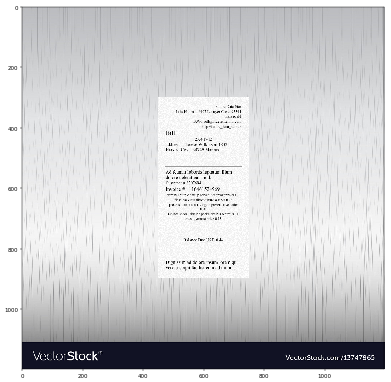

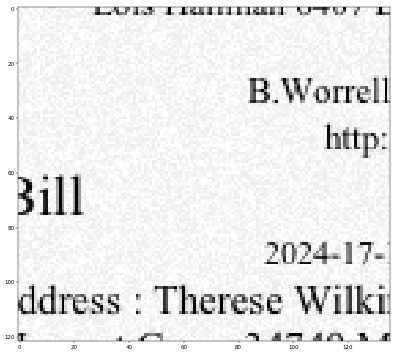

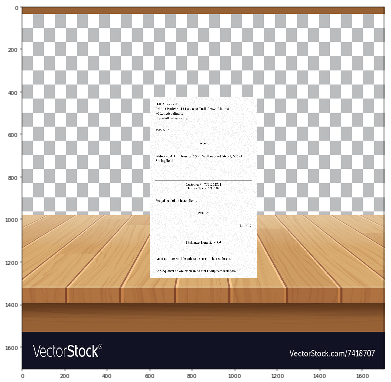

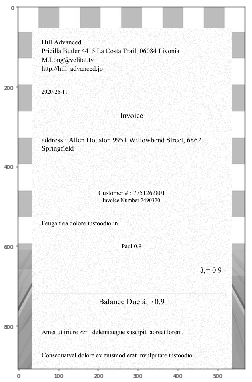

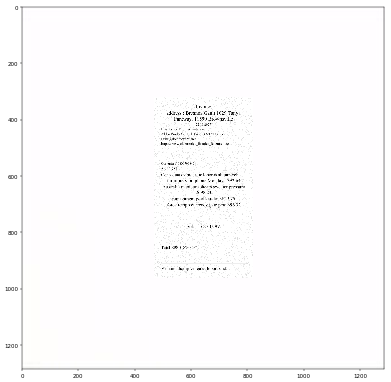

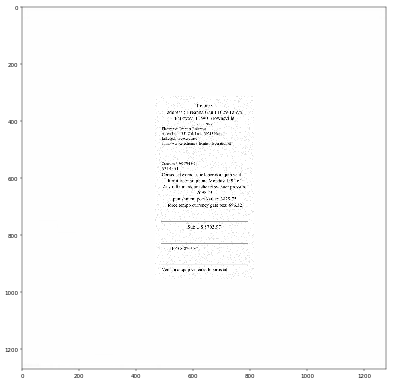

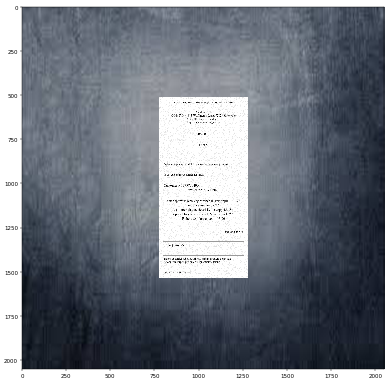

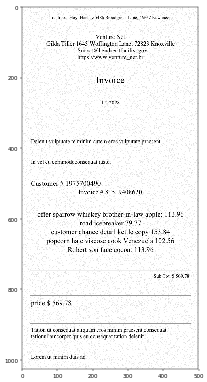

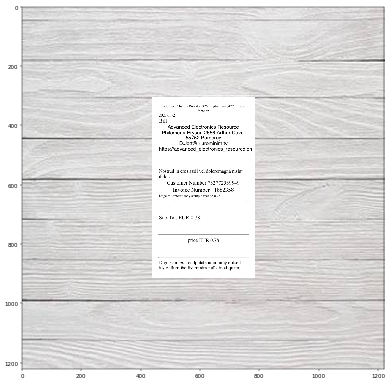

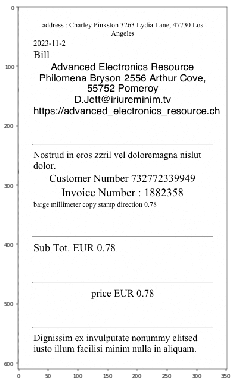

In [14]:
for i in range(5):
    input_img = get_image(background_img_names, input_img_names, max_foreground_size, scaler)
    img_show(input_img, 12)

    bounding_box_img, cropped_img = crop_background(input_img) # , True
    img_show(cropped_img, 12, True)

    cv2.imwrite("%s/%i_cropped.png" % (test_folder_name, i), cropped_img)
    cv2.imwrite("%s/%i_box.png" % (test_folder_name, i), bounding_box_img)
    
"""
Conclusion:
    Contrast has to be set to at least 240-250 to crop out gray backgrounds.
    White backgrounds are impossible to crop with this method as thresholds
    are used which don't work if the paper color is the same as the background.
    It would be better if there was no contrast issue, but this can probably
    only be solved using machine learning.
"""

## Test rotation augmentation

angle correction: 3.911572, angle error: 0.031001
angle correction: -33.299419, angle error: 0.027510
angle correction: -27.362011, angle error: 0.089734
angle correction: -0.000000, angle error: 6.432663
angle correction: -0.000000, angle error: 37.987905


"\nConclusion:\n    doesn't work that well.\n"

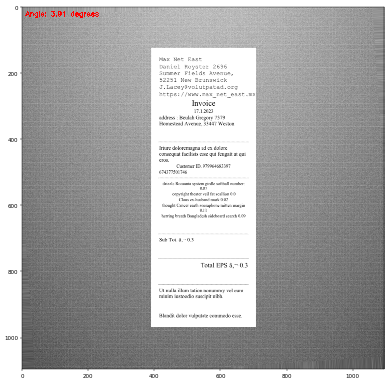

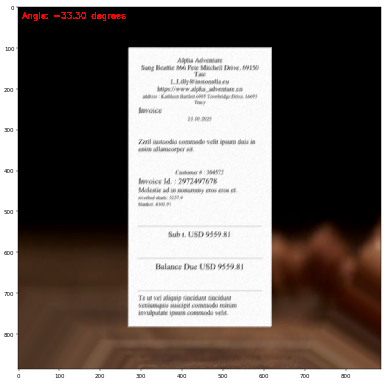

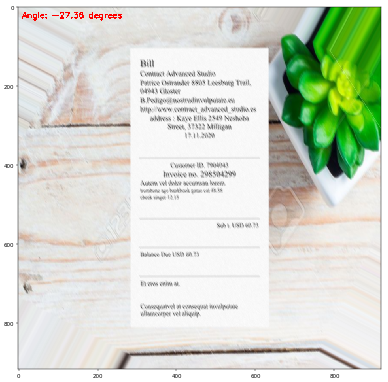

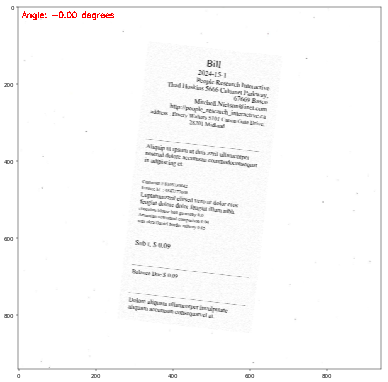

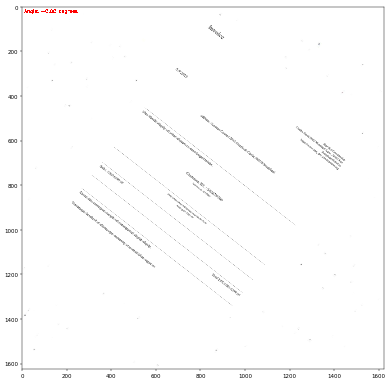

In [15]:
for i in range(5):
    distorted_image, rotation, shear = distort_image(background_img_names, input_img_names)
#     img_show(distorted_image, 12, False)

    open_cv_image, angle = get_angle_opencv(distorted_image, False)
    print("angle correction: %f, angle error: %f" % (angle, np.abs(rotation-angle)))
    rotated = correct_rotation(open_cv_image, angle)
    
"""
Conclusion:
    doesn't work that well.
"""

## Line Segmentation (when image is cropped and rotated)

In [16]:
def segment_lines(input_img, dev=False):
    """
    Function which semgements lines.
    """
    
    # (1) convert to CV2
    img_rgb = np.array(input_img.convert('RGB'))
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
    if(dev):
        img_show(gray, 12, True)

    # (2) gray -> black & white
    frame_threshed = cv2.inRange(gray, 127, 255)
    if(dev):
        img_show(frame_threshed, 12, True)

    # (3) get thresholds
    ret,thresh = cv2.threshold(frame_threshed,127,255,0)
    contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    # contours, hierarchy
    if(dev):
        img_show(thresh, 12, True)

    ## (5) find and draw the upper and lower boundary of each lines
    hist = cv2.reduce(thresh,1, cv2.REDUCE_AVG).reshape(-1)

    th = 2
    H,W = thresh.shape[:2]
    uppers = [y for y in range(H-1) if hist[y]<=th and hist[y+1]>th]
    lowers = [y for y in range(H-1) if hist[y]>th and hist[y+1]<=th]

    rotated = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)
    for y in uppers:
        cv2.line(rotated, (0,y), (W, y), (255,0,0), 1)

    for y in lowers:
        cv2.line(rotated, (0,y), (W, y), (0,255,0), 1)

#     if(dev):
    img_show(rotated, 12, True)

    seg_img = rotated

    return seg_img

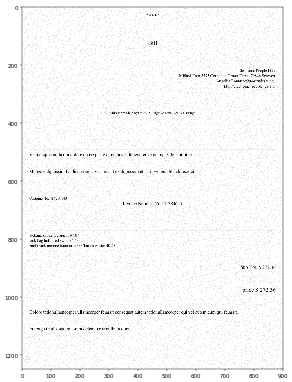

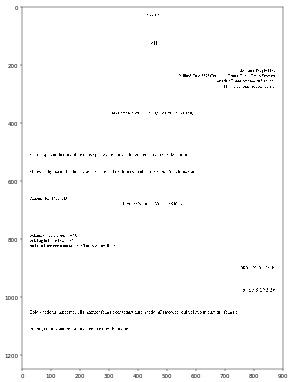

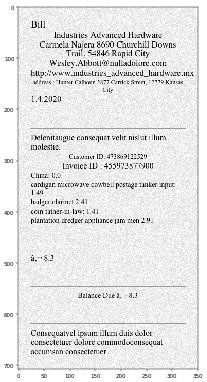

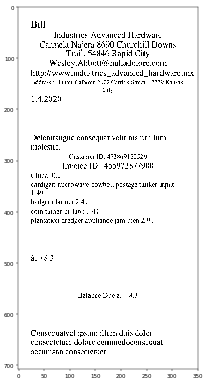

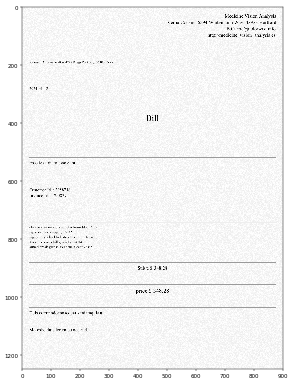

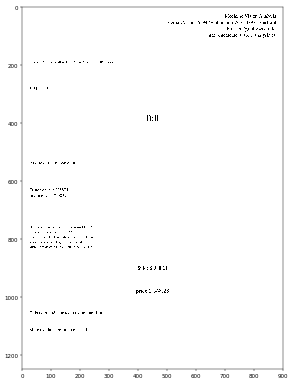

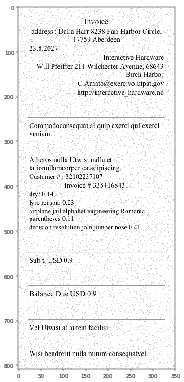

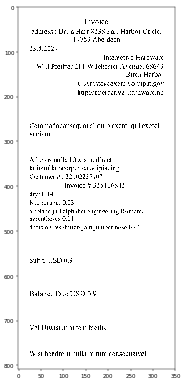

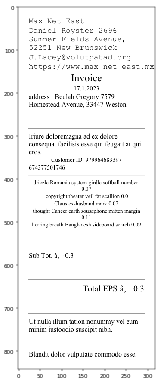

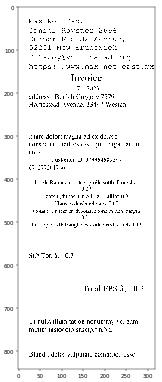

In [17]:
for i in range(5):
#     input_img = get_image(background_img_names, input_img_names, max_foreground_size, scaler)
    input_img = Image.open(os.path.join(input_data_folder, random.choice(input_img_names)))
    img_show(input_img, 12)

    seg_img = segment_lines(input_img, False)
#     img_show(seg_img, 12, True)

In [21]:
def segment_image(input_img):
    """
    https://stackoverflow.com/questions/34981144/split-text-lines-in-scanned-document
    """
    img = np.array(input_img.convert('RGB'))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    ## (2) threshold
    th, threshed = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)

    ## (3) find and draw the upper and lower boundary of each lines
    hist = cv2.reduce(threshed,1, cv2.REDUCE_AVG).reshape(-1)

    th = 2
    H,W = img.shape[:2]
    uppers = [y for y in range(H-1) if hist[y]<=th and hist[y+1]>th]
    lowers = [y for y in range(H-1) if hist[y]>th and hist[y+1]<=th]

    threshed = cv2.cvtColor(threshed, cv2.COLOR_GRAY2BGR)
    for y in uppers:
        cv2.line(threshed, (0,y), (W, y), (255,0,0), 1)

    for y in lowers:
        cv2.line(threshed, (0,y), (W, y), (0,255,0), 1)

    # img_show(threshed, 12*3, True)
    return threshed, img, uppers, lowers

'\nConclusion:\n    Works sometimes, not reliable.\n'

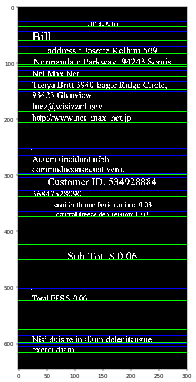

In [22]:
for i in range(1):
    input_img = Image.open(os.path.join(input_data_folder, random.choice(input_img_names)))
    img_w_lines, original_img, uppers, lowers = segment_image(input_img)
    img_show(img_w_lines, 12, True)

    if (len(uppers) != len(lowers)):
        raise SystemError

    for i in range(len(uppers)):
        cv2.imwrite("%s/segment_%i.png" % (test_folder_name, i), original_img[uppers[i]-2:lowers[i]+3, :])

"""
Conclusion:
    Works sometimes, not reliable.
"""